In [1]:
import numpy as np
import pandas as pd

In [2]:
abc_df = pd.read_csv('ABC_Feature_Matrix_Random.csv')
jwst_df = pd.read_csv('Interpolated_WASP-39b.csv')

In [3]:
x_spec = abc_df.iloc[:, 1:53]
y = abc_df.iloc[:, 53]

In [4]:
x_jwst = jwst_df.iloc[:,1:]

In [5]:
#Train Test Split
from sklearn.model_selection import train_test_split
x_spec_train, x_spec_test, y_train, y_test = train_test_split(x_spec, y, test_size = 0.2, random_state = 42)

In [6]:
X_train = x_spec_train.to_numpy()
X_test = x_spec_test.to_numpy()
X_jwst = x_jwst.to_numpy()

In [7]:
from sklearn.preprocessing import Normalizer

#Normalization using norm = max

scaler_norm = Normalizer(norm = 'max')

x_train_nmax = scaler_norm.fit_transform(X_train)
x_test_nmax = scaler_norm.transform(X_test)
x_jwst_nmax = scaler_norm.transform(X_jwst)

In [8]:
#Normmalization using norm = max and adding max column

x_train_nm_max = np.hstack([x_train_nmax,X_train.max(axis=1, keepdims=True)])
x_test_nm_max = np.hstack([x_test_nmax,X_test.max(axis=1, keepdims=True)])
x_jwst_nm_max = np.hstack([x_jwst_nmax,X_jwst.max(axis=1, keepdims=True)])

In [9]:
y_train = np.log1p(y_train)
y_test   = np.log1p(y_test)

In [10]:
import optuna
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    x_train_nm_max, y_train, test_size=0.20, random_state=42
)

def objective(trial):

    # Depth: restrict to 1–2 layers (3+ is too slow)
    n_layers = trial.suggest_int("n_layers", 1, 2)

    # Width: 64–192 units per layer (good speed/accuracy balance)
    hidden_layer_sizes = tuple([
        trial.suggest_int(f"units_l{i}", 64, 192, step=64)
        for i in range(n_layers)
    ])

    params = {
        "hidden_layer_sizes": hidden_layer_sizes,
        "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
        "solver": "adam",        # fastest for 20k × 55 data
        "alpha": trial.suggest_float("alpha", 1e-6, 1e-2, log=True),
        "learning_rate": trial.suggest_categorical("learning_rate", ["constant", "adaptive"]),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [64, 128, 256]),
        "max_iter": 300,
        "early_stopping": True,
        "validation_fraction": 0.15,
        "random_state": 42,
    }

    model = MLPRegressor(**params)
    model.fit(X_tr, y_tr)

    preds = model.predict(X_val)
    r2 = r2_score(y_val, preds)

    trial.report(r2, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return r2


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best R2:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-11-26 11:54:47,203] A new study created in memory with name: no-name-5967953a-4089-4d43-9621-fc9e77f6298f


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-26 11:57:34,606] Trial 0 finished with value: 0.8661954578526098 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 128, 'activation': 'relu', 'alpha': 0.0005835225379501063, 'learning_rate': 'constant', 'learning_rate_init': 0.00041937309561917914, 'batch_size': 128}. Best is trial 0 with value: 0.8661954578526098.


C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 11:59:20,957] Trial 1 finished with value: 0.6701946023987329 and parameters: {'n_layers': 1, 'units_l0': 64, 'activation': 'relu', 'alpha': 0.0009474439797502298, 'learning_rate': 'constant', 'learning_rate_init': 0.00040443229785965164, 'batch_size': 128}. Best is trial 0 with value: 0.8661954578526098.
[I 2025-11-26 12:00:53,304] Trial 2 finished with value: 0.6520368136569198 and parameters: {'n_layers': 2, 'units_l0': 192, 'units_l1': 192, 'activation': 'relu', 'alpha': 0.0038592402491226824, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003625438002459324, 'batch_size': 64}. Best is trial 0 with value: 0.8661954578526098.
[I 2025-11-26 12:03:16,116] Trial 3 finished with value: 0.8177406253690875 and parameters: {'n_layers': 1, 'units_l0': 128, 'activation': 'relu', 'alpha': 0.0009578190532165141, 'learning_rate': 'constant', 'learning_rate_init': 0.0007029465164657571, 'batch_size': 128}. Best is trial 0 with value: 0.8661954578526098.
[I 2025-11-26 12:07:32

C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 12:12:47,413] Trial 5 finished with value: 0.868312512321183 and parameters: {'n_layers': 2, 'units_l0': 192, 'units_l1': 128, 'activation': 'tanh', 'alpha': 2.0152219412465235e-06, 'learning_rate': 'constant', 'learning_rate_init': 0.0003415524437723792, 'batch_size': 256}. Best is trial 4 with value: 0.9126601033046416.
[I 2025-11-26 12:14:59,461] Trial 6 pruned. 
[I 2025-11-26 12:15:54,470] Trial 7 pruned. 
[I 2025-11-26 12:16:52,472] Trial 8 pruned. 
[I 2025-11-26 12:17:27,175] Trial 9 pruned. 


C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 12:19:32,105] Trial 10 finished with value: 0.8860488626947436 and parameters: {'n_layers': 2, 'units_l0': 128, 'units_l1': 64, 'activation': 'tanh', 'alpha': 3.311986804744165e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001046699279706816, 'batch_size': 64}. Best is trial 4 with value: 0.9126601033046416.


C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 12:21:37,016] Trial 11 finished with value: 0.8862059927489648 and parameters: {'n_layers': 2, 'units_l0': 128, 'units_l1': 64, 'activation': 'tanh', 'alpha': 2.255297028982562e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010398952707859123, 'batch_size': 64}. Best is trial 4 with value: 0.9126601033046416.


C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 12:23:39,309] Trial 12 finished with value: 0.8815081480964101 and parameters: {'n_layers': 2, 'units_l0': 128, 'units_l1': 64, 'activation': 'tanh', 'alpha': 2.4119848419668163e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010001516389803288, 'batch_size': 64}. Best is trial 4 with value: 0.9126601033046416.


C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 12:24:58,556] Trial 13 finished with value: 0.8989203206326053 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 64, 'activation': 'tanh', 'alpha': 3.474281230701593e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001840763595139117, 'batch_size': 64}. Best is trial 4 with value: 0.9126601033046416.
[I 2025-11-26 12:26:33,996] Trial 14 finished with value: 0.8883044386956731 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 128, 'activation': 'tanh', 'alpha': 7.97520150937412e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00020813476283382962, 'batch_size': 64}. Best is trial 4 with value: 0.9126601033046416.
[I 2025-11-26 12:27:15,847] Trial 15 finished with value: 0.9148174830628523 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 64, 'activation': 'tanh', 'alpha': 8.577168347064588e-06, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009223317318788121, 'batch_size': 64}. Best is trial 15 with value: 0.91481748

C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 12:30:14,515] Trial 20 pruned. 


C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 12:31:35,054] Trial 21 finished with value: 0.9155015018511962 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 64, 'activation': 'tanh', 'alpha': 1.5184394784281626e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00022195728709078209, 'batch_size': 64}. Best is trial 21 with value: 0.9155015018511962.


C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 12:32:52,973] Trial 22 finished with value: 0.9158797070342671 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 64, 'activation': 'tanh', 'alpha': 1.2137935519138352e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002568905599861014, 'batch_size': 64}. Best is trial 22 with value: 0.9158797070342671.
[I 2025-11-26 12:33:37,956] Trial 23 finished with value: 0.9105203664220882 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 64, 'activation': 'tanh', 'alpha': 1.0912284853487332e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006023944689928221, 'batch_size': 64}. Best is trial 22 with value: 0.9158797070342671.


C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 12:34:56,514] Trial 24 finished with value: 0.8929389381115135 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 64, 'activation': 'tanh', 'alpha': 1.3037270811666336e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017141090972437855, 'batch_size': 64}. Best is trial 22 with value: 0.9158797070342671.
[I 2025-11-26 12:35:25,648] Trial 25 finished with value: 0.8972750758018742 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 64, 'activation': 'tanh', 'alpha': 4.027157766470047e-06, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014633108494293214, 'batch_size': 64}. Best is trial 22 with value: 0.9158797070342671.
[I 2025-11-26 12:36:32,562] Trial 26 pruned. 
[I 2025-11-26 12:37:03,893] Trial 27 pruned. 
[I 2025-11-26 12:37:55,179] Trial 28 finished with value: 0.8907024915061532 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 64, 'activation': 'tanh', 'alpha': 3.8901565593491725e-05, 'learning_rate': 'adaptive', 'learni

C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 12:49:50,276] Trial 33 finished with value: 0.9041461974334739 and parameters: {'n_layers': 2, 'units_l0': 128, 'units_l1': 192, 'activation': 'tanh', 'alpha': 1.6300301387317172e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00014170479015174437, 'batch_size': 64}. Best is trial 22 with value: 0.9158797070342671.
[I 2025-11-26 13:01:46,014] Trial 34 pruned. 


C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 13:02:49,806] Trial 35 pruned. 
[I 2025-11-26 13:04:21,769] Trial 36 pruned. 
[I 2025-11-26 13:05:42,471] Trial 37 pruned. 


C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 13:07:45,310] Trial 38 finished with value: 0.8942909118426979 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 64, 'activation': 'tanh', 'alpha': 3.7820070612029534e-06, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00032775557543383784, 'batch_size': 128}. Best is trial 22 with value: 0.9158797070342671.
[I 2025-11-26 13:08:37,977] Trial 39 pruned. 
Best R2: 0.9158797070342671
Best Params: {'n_layers': 2, 'units_l0': 64, 'units_l1': 64, 'activation': 'tanh', 'alpha': 1.2137935519138352e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002568905599861014, 'batch_size': 64}


In [11]:
best = study.best_params

# Rebuild hidden_layer_sizes
n_layers = best["n_layers"]
hidden_layer_sizes = tuple([
    best[f"units_l{i}"] for i in range(n_layers)
])

# Remove Optuna-only keys
best_nm_max = best.copy()
best_nm_max.pop("n_layers")
for i in range(n_layers):
    best_nm_max.pop(f"units_l{i}")

# Inject the real MLP param
best_nm_max["hidden_layer_sizes"] = hidden_layer_sizes

mlp_nm_max = MLPRegressor(**best_nm_max)
mlp_nm_max.fit(x_train_nm_max, y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(64, ...)"
,activation,'tanh'
,solver,'adam'
,alpha,1.2137935519138352e-05
,batch_size,64
,learning_rate,'adaptive'
,learning_rate_init,0.0002568905599861014
,power_t,0.5
,max_iter,200
,shuffle,True


In [14]:
from sklearn.neural_network import MLPRegressor
best_nm_max =   {'activation': 'tanh', 'alpha': 1.2137935519138352e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002568905599861014, 'batch_size': 64, 'hidden_layer_sizes': (64, 64)}
mlp_nm_max = MLPRegressor(**best_nm_max)
mlp_nm_max.fit(x_train_nm_max, y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(64, ...)"
,activation,'tanh'
,solver,'adam'
,alpha,1.2137935519138352e-05
,batch_size,64
,learning_rate,'adaptive'
,learning_rate_init,0.0002568905599861014
,power_t,0.5
,max_iter,200
,shuffle,True


In [19]:
import joblib
mlp_nm_max=joblib.load( "mlp_nm_max.pkl")

In [20]:
y_test_pred_nm_max =  mlp_nm_max.predict(x_test_nm_max)

In [21]:
from sklearn.metrics import r2_score

results = {
    "mlp_nm_max": [r2_score(y_train, mlp_nm_max.predict(x_train_nm_max)), r2_score(y_test, mlp_nm_max.predict(x_test_nm_max))]
}

In [22]:
result_df = pd.DataFrame(results, index=["train", "test"])
result_df

,mlp_nm_max
train,0.901732
test,0.904920


In [23]:
from sklearn.metrics import mean_absolute_error

results_mae = {
    "mlp_nm_max": [mean_absolute_error(y_train, mlp_nm_max.predict(x_train_nm_max)), mean_absolute_error(y_test, mlp_nm_max.predict(x_test_nm_max))]
}

result_mae_df = pd.DataFrame(results_mae, index=["train", "test"])
result_mae_df

,mlp_nm_max
train,0.104395
test,0.101294


In [24]:
from sklearn.metrics import mean_squared_error

results_mse = {
    "mlp_nm_max": [mean_squared_error(y_train, mlp_nm_max.predict(x_train_nm_max)), mean_squared_error(y_test, mlp_nm_max.predict(x_test_nm_max))]
}

result_mse_df = pd.DataFrame(results_mse, index=["train", "test"])
result_mse_df

,mlp_nm_max
train,0.030310
test,0.028797


In [25]:
result_rmse_df = np.sqrt(result_mse_df)
result_rmse_df

,mlp_nm_max
train,0.174098
test,0.169697


In [14]:
y_nm_max = np.expm1(mlp_nm_max.predict(x_jwst_nm_max))

In [15]:
print("MLP NM MAX: ", y_nm_max.mean(axis = 0))

MLP NM MAX:  -0.9952688869101989


In [16]:
print("mlp nm max params : ",best_nm_max)

mlp nm max params :  {'activation': 'tanh', 'alpha': 1.2137935519138352e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002568905599861014, 'batch_size': 64, 'hidden_layer_sizes': (64, 64)}


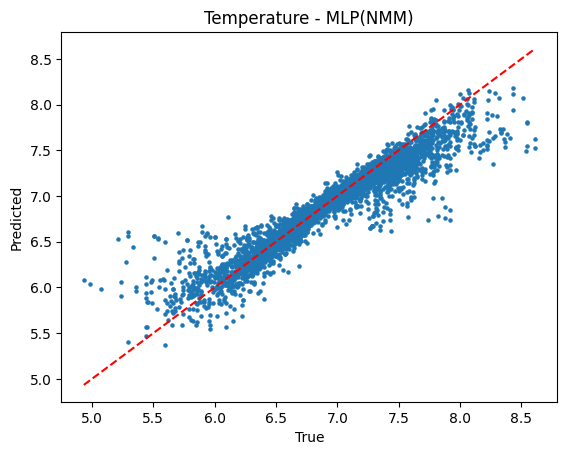

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(y_test, y_test_pred_nm_max, s=5)

m = min(y_test.min(), y_test_pred_nm_max.min())
M = max(y_test.max(), y_test_pred_nm_max.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature - MLP(NMM)")
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_14400\153166175.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_14400\153166175.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_14400\153166175.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

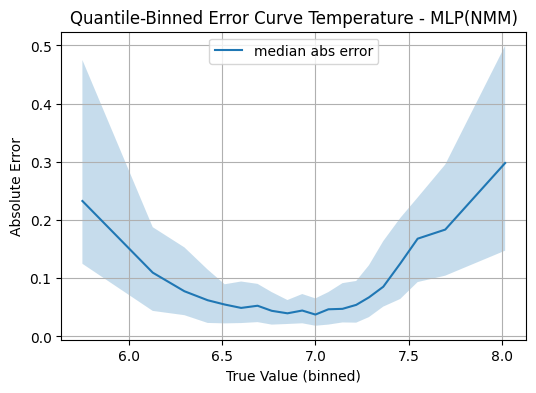

In [18]:
true = y_test       # 1D array
pred = y_test_pred_nm_max  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature - MLP(NMM)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import joblib

# suppose your trained model is 'model'
joblib.dump(mlp_nm_max, "mlp_nm_max.pkl")


['mlp_nm_max.pkl']